# Measurement and Analysis of Online Social Networks
**Mislove_2007 / IMC2007**

APan 2020/9/4

## Core motivation

This paper presents a **large-scale** measurement study and analysis of the structure of multiple online social networks.

## Key elements of the approach

- crawl 4 network datasets

| Name | Nodes | Edges | File Size |
|  ----  | ----  |  ----  | ----  |
|Flickr |1,846,198|22,613,981|107.80mb|
|LiveJournal 2006|5,284,457|77,402,652|725.00mb|
|Orkut 2006|3,072,448|223,534,301|2.07gb|
|YouTube 2007|1,157,827|4,945,382|21.50mb|

- WCC = forward links(you follow who) + backward links(who follow you)

    Using only forward links does not necessarily crawl an entire WCC
- Flickr only allows us to query for forward links. How to calculate the fraction of network covered by our crawl?

    1. generate a random sample of social network users $S$.(We used the fact that the vast majority of Flickr user identifiers take the form of [randomly selected 8 digit number]@N00.)
    2. among $S$, $S_{crawl}$ has been discovered.
    3. conduct a BFS starting at each user from $S_{not found} = S - S_{crawl}$ and find the partition of missing users who could reach crawled set and are definitively in the WCC, for example, only xx users are in the WCC but missed.
    4. describe the remaining missing users, e.g., singleton nodes with no forward links, low degree and are connected only to small clusters that are not reachable from the large connected component.

## Contribution

- Our data set contains over 11.3 million users and 328 million links. We believe that this is the first study to examine multiple online social networks at scale.

- 80% photos were located by traversing the social network links.(Information flows through links)

- Crawling only a subset of a graph by ending a BFS early (called the snowball method) is known to produce a biased sample of nodes. In particular, partial BFS crawls are likely to overestimate node degree and underestimate the level of symmetry.

## To dos

---

# Analysis

LiveJournal and Orkut are too large for calculation. Here we use Flickr and YouTube network.

## Load data

In [1]:
import networkx as nx

### Load network

In [2]:
def load_network(data):
    """Load network data.

    Parameters
    ----------
    data : list of string
        rows: [['1 2'],
               ['1 3']] 

    Returns
    -------
    G: networkx.Graph
    """

    import networkx as nx

    G = nx.DiGraph()

    for l in data:
        temp = l.split()
        G.add_edge(int(temp[0]), int(temp[1]))

    print(nx.info(G))

    return G

In [4]:
url = '../network data collection/Flickr/flickr-links.txt'

with open(url) as f:
    data = f.readlines()

print(data[:5])

In [5]:
G_flickr = load_network(data)

In [6]:
del data

In [3]:
url = '../network data collection/Youtube/youtube-links.txt'

with open(url) as f:
    data = f.readlines()

print(data[:5])

['1\t2\n', '1\t3\n', '1\t4\n', '1\t5\n', '1\t6\n']


In [4]:
G_youtube = load_network(data)

Name: 
Type: DiGraph
Number of nodes: 1138499
Number of edges: 4945382
Average in degree:   4.3438
Average out degree:   4.3438


In [5]:
del data

## Network Statistics

In [5]:
import plotly.io as pio
pio.renderers.default = "svg"

In [6]:
Gcc_youtube_nodes = max(nx.weakly_connected_components(G_youtube), key=len)
Gcc_youtube = nx.subgraph(G_youtube, Gcc_youtube_nodes)

In [7]:
del G_youtube
del Gcc_youtube_nodes

In [8]:
print(nx.info(Gcc_youtube))

Name: 
Type: DiGraph
Number of nodes: 1134890
Number of edges: 4942035
Average in degree:   4.3546
Average out degree:   4.3546


### Link symmetry

In [9]:
def link_sym(Gcc):
    """
    fraction of reciprocal links
    """
    edges_und = [(min(u, v), max(u, v)) for (u, v) in Gcc.edges()]
    edges_und_set = set(edges_und)

    return len(Gcc.edges()) / len(edges_und_set) - 1

In [11]:
print('Link symmetry of Youtube is %.2f' % link_sym(Gcc_youtube))

Link symmetry of Youtube is 0.65


### Power-law

In [10]:
from sklearn.linear_model import LinearRegression
import numpy as np
import collections
import plotly.graph_objects as go


def get_deg_prob(Gcc):
    """Get Gcc's degree sequence and probability sequence.

    Parameters
    ----------
    Gcc : nx.Graph

    Returns
    -------
    deg: array of int
        degree

    prob: array of float
        probability
    """

    degree_sequence = sorted([d for n, d in Gcc.degree()],
                             reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    deg = np.array(deg)
    cnt = np.array(cnt)
    # avoid 0-degree and log(0)
    cnt = cnt[deg > 0]
    deg = deg[deg > 0]

    prob = cnt / sum(cnt)

    return deg, prob


def deg_prob_regression(X, Y):
    """Regression on degree and probability

    Parameters
    ----------
    X: array of int
        degree

    Y: array of float
        probability

    Returns
    -------
    X_fit: np.array
        values of X

    Y_fit: np.array
        fitting values of Y

    slope: float
        coefficient of ols fitting

    """

    model = LinearRegression()
    model.fit(np.log(X).reshape(-1, 1), np.log(Y))

    y_fit = model.predict(np.log(X).reshape(-1, 1))
    Y_fit = np.exp(y_fit)

    X_fit = X
    slope = model.coef_[0]

    return X_fit, Y_fit, slope


def plot_deg_distribution(Gcc):
    """Plot degree distriburion of Gcc on log-log scale.

    Parameters
    ----------
    Gcc : nx.Graph

    """
    deg, cnt = get_deg_prob(Gcc)
    X_fit, Y_fit, slope = deg_prob_regression(deg, cnt)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=deg, y=cnt, mode='markers'))
    fig.add_trace(go.Scatter(x=deg, y=Y_fit,
                             name='regression slope = %.2f' % slope))

    fig.update_xaxes(title_text="Degree", type="log")
    fig.update_yaxes(title_text="Probability", type="log")
    fig.update_layout(title_text="Degree distribution on log-log scale")

    fig.show()

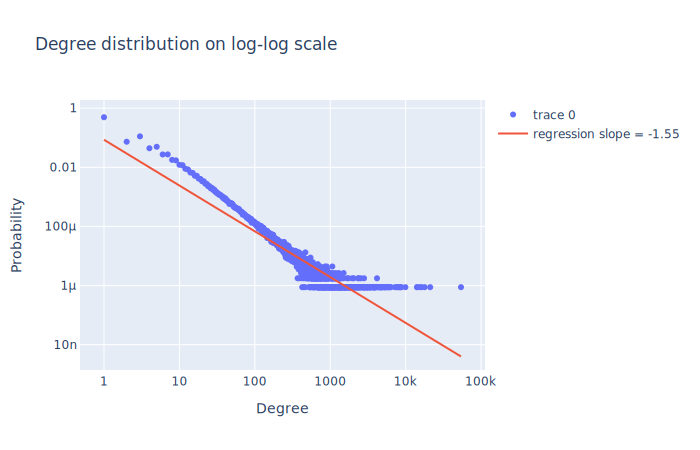

In [11]:
plot_deg_distribution(Gcc_youtube)

### correlation of indegree and outdegree

In [12]:
out_degs = list(Gcc_youtube.out_degree())
user_out_deg = sorted(out_degs, key=lambda x: x[1], reverse=True)

In [13]:
in_degs = list(Gcc_youtube.in_degree())
user_in_deg = sorted(in_degs, key=lambda x: x[1], reverse=True)

In [14]:
import numpy as np
fractions = np.arange(1, len(out_degs), 10000)

In [15]:
overlaps = []
for frac in fractions:
    user_set_out = set([i[0] for i in user_out_deg[:frac]])
    user_set_in = set([i[0] for i in user_in_deg[:frac]])
    overlaps.append(len(user_set_out & user_set_in) / frac)

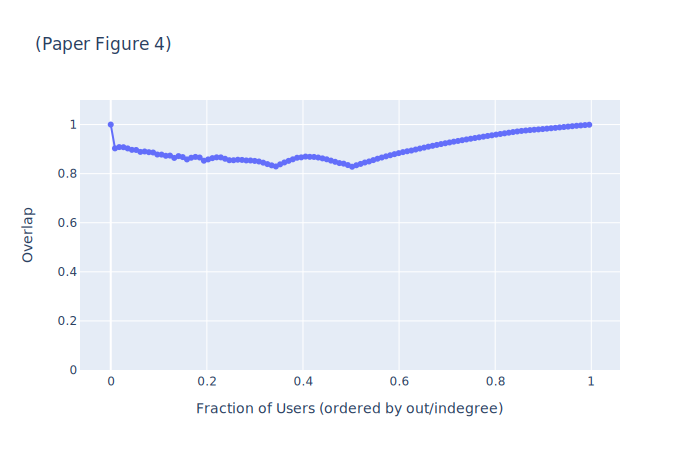

In [16]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=fractions / len(out_degs),
                         y=overlaps, mode='markers+lines'))
fig.update_xaxes(title_text="Fraction of Users (ordered by out/indegree)")
fig.update_yaxes(title_text="Overlap", range=[0, 1.1])
fig.update_layout(
    title='(Paper Figure 4)')

fig.show()